# Application of Decision Trees

We first use scikit-learn module to train a decision tree on the training set for prediction.


### 1. Data Loading

We first load the training set and the test set (.NPY files).

In [1]:
import numpy as np
xs_test = np.load('data/xs_test.npy')
xs_train = np.load('data/xs_train.npy')
ys_test = np.load('data/ys_test.npy')
ys_train = np.load('data/ys_train.npy')

What's more, the dictionary files (.CSV) are also loaded.

In [2]:
import csv

att_dic = {}
class_dic = {}

# read the .csv files back to the dictionaries
with open('data/att_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        att_dic[row[0]]=row[1]

with open('data/class_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        class_dic[row[0]] = row[1]

### 2. Parameter Tuning

The DecisionTreeClassifier() method in sklearn package provides a large number of parameters. Here we focus on tuning 5 of them:


- <b>class_weight:</b> A parameter which can be set as 'balanced' or None. When it is set as 'balanced', each class will be assigned with a weight inversely according to its frequency, which may improve the performance of the model when the dataset is imbalanced.

- <b>criterion:</b> A parameter which can be set as 'gini' or 'entropy', which determines the method used to measure the purity when splitting the tree.

- <b>max_depth:</b> A parameter which can be set as any integer greater than 0. It controls the maximum depth of a tree, which is useful to avoid overfitting.

- <b>min_samples_split:</b> A parameter which can be set as any integer greater than 1. It controls the minimum number of instances required to split a non-leaf node, which is useful to avoid overfitting.

- <b>min_samples_leaf:</b> A parameter which can be set as any integer greater than 0. It controls the minimum number of instances required to form a leaf node, which is also useful to avoid overfitting.


Thus, to discover which criterion, what depth, min_samples_split and min_samples_leaf can lead to better model performance, <b>sklearn.model_selection.GridSearchCV</b> is used to perform 5-fold cross-validation on the training set. 

In each hyper-parameter combinations setting, the training set is randomly split into 5 groups. Each group will be used as the validation set once to estimate the performance of the model which is trained with the rest groups. Since the dataset is imbalanced, the accuracy score can be high even when the model is not good (e.g., if the model predict all the samples as UNACC, the accuracy score can be still greater than 70%). As a result, here weighted F1 score (the mean of all per-class F1 scores considering each class’s support) is utilized to evaluate the performance of the parameter combination.


After calculating the performance metrics in different parameter settings, the tree with the highest weighted F1 score will be set as the best estimator.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold

# set 2 criterion options (entropy and gini), max_depth from 1 to 25, min_samples_split from 2 to 5, min_samples_leaf from 1 to 5
param_grid = [{
    'class_weight': ['balanced', None],
    'criterion': ["entropy", "gini"],
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 5, 1),
    'min_samples_leaf': range(1, 5, 1)
}]

tree_clf = DecisionTreeClassifier(random_state=66)
# try each hyper-parameter combination with GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=41)
grid_search = GridSearchCV(tree_clf, param_grid, cv=cv,
                           verbose=1, scoring='f1_weighted')
grid_result = grid_search.fit(xs_train, ys_train)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


Then, we check the best hyper-parameter combination.

In [4]:
# print the best parameter combination
for param in grid_search.best_params_:
    print('Best', param, 'is :',grid_search.best_params_[param])

Best class_weight is : balanced
Best criterion is : gini
Best max_depth is : 11
Best min_samples_leaf is : 1
Best min_samples_split is : 3


We can visualize the weighted F1 score on the validation set in different hyper-parameter settings. According to the chart, when min_samples_leaf = 1, min_samples_split = 3 and class_weight='balanced' in both criterion settings, the model has fit well when the depth is approximately 15.

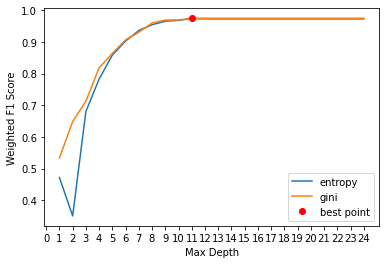

In [5]:
import matplotlib.pyplot as plt

mean_score = grid_search.cv_results_['mean_test_score']

# print(grid_search.cv_results_)
f1_entropy = [None]
f1_gini = [None]

# append the weighted F1 score in different depth settings to two list
for i in range(len(mean_score)):
    if grid_search.cv_results_['param_criterion'][i] == 'entropy' and grid_search.cv_results_['param_min_samples_leaf'][i] == grid_search.best_params_['min_samples_leaf'] and grid_search.cv_results_['param_min_samples_split'][i] == grid_search.best_params_['min_samples_split'] and grid_search.cv_results_['param_class_weight'][i] == grid_search.best_params_['class_weight']:
        f1_entropy.append(mean_score[i])
    elif grid_search.cv_results_['param_criterion'][i] == 'gini' and grid_search.cv_results_['param_min_samples_leaf'][i] == grid_search.best_params_['min_samples_leaf'] and grid_search.cv_results_['param_min_samples_split'][i] == grid_search.best_params_['min_samples_split'] and grid_search.cv_results_['param_class_weight'][i] == grid_search.best_params_['class_weight']:
        f1_gini.append(mean_score[i])

# plot the curve of entropy and gini
plt.plot(f1_entropy, label='entropy')
plt.plot(f1_gini, label='gini')

# plot the point with the biggest F1 score
if grid_search.best_params_['criterion'] == 'gini':
    best_f1 = f1_gini[grid_search.best_params_['max_depth']]
else:
    best_f1 = f1_entropy[grid_search.best_params_['max_depth']]
plt.plot(grid_search.best_params_['max_depth'],best_f1,'ro',label='best point')

# set the lable of the graph
plt.xlabel('Max Depth')
plt.ylabel('Weighted F1 Score')
plt.xticks(np.arange(0,25,1))

# plot the legend of the graph
plt.legend(loc='lower right')

### 3. Model Training and Evaluation

Then, with the best hyper-parameters, we learn a decition tree on the training set.

In [6]:
# create and train a decision tree with the best hyper-parameters
tree_clf = DecisionTreeClassifier(class_weight=grid_search.best_params_['class_weight'],criterion=grid_search.best_params_['criterion'], max_depth=grid_search.best_params_['max_depth'],min_samples_leaf=grid_search.best_params_['min_samples_leaf'],min_samples_split=grid_search.best_params_['min_samples_split'],random_state=66)
tree_clf.fit(xs_train, ys_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=11,
                       min_samples_split=3, random_state=66)

In order to use the model again in the Model Ensemble Part, we save the model with joblib() method in sklearn.

In [7]:
import joblib
# save the trained decision tree model
joblib.dump(tree_clf, 'models/Decision_Tree.model')

['models/Decision_Tree.model']

To visualise the decition tree, we have to first install graphviz module.

In [8]:
# %conda install graphviz

Then, we visualise the decision tree with different colors according to the class names and the attributes names.

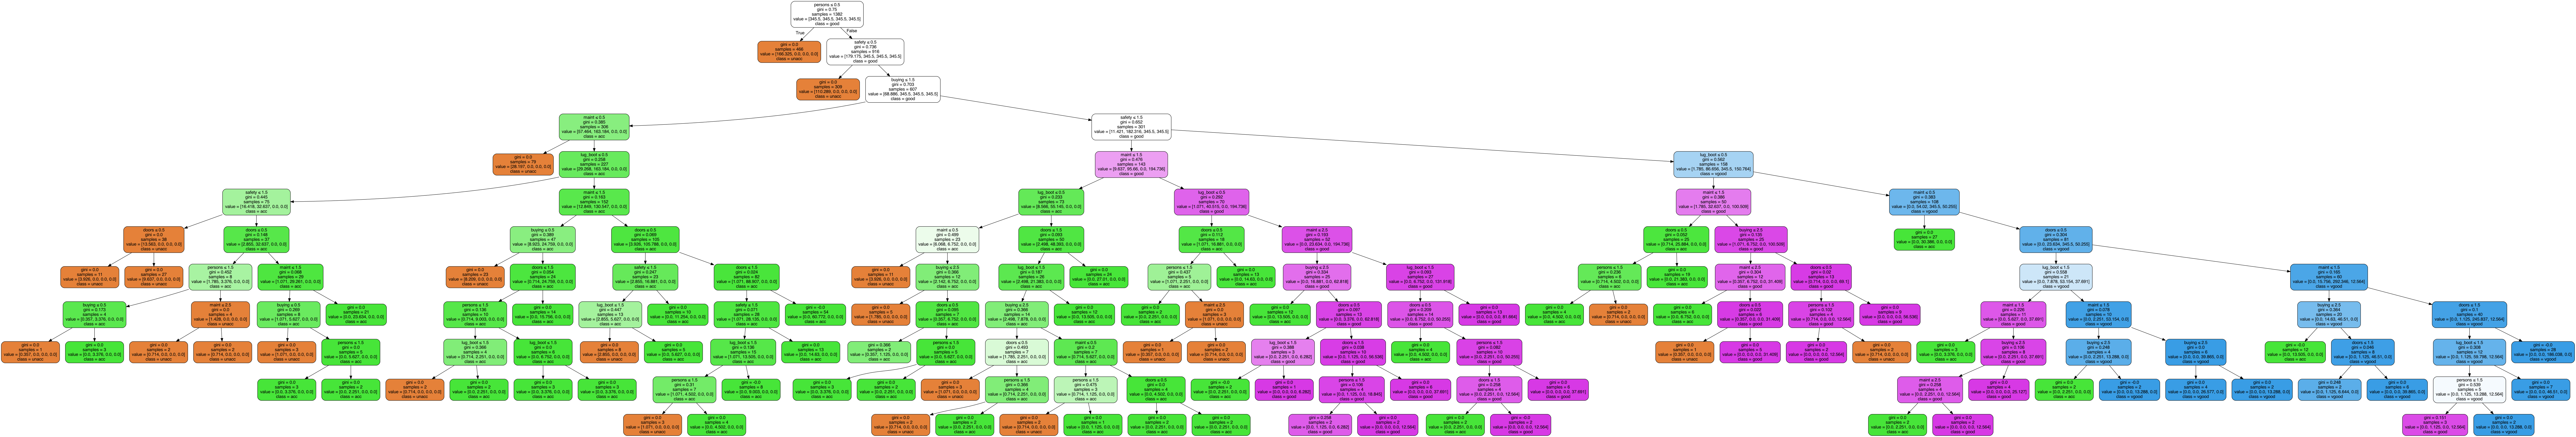

In [9]:
import graphviz
from sklearn import tree
from IPython.display import Image

# first transform the tree to dot format
dot_data = tree.export_graphviz(tree_clf, feature_names=[i for i in att_dic],
                                class_names=[class_dic[j] for j in class_dic],
                                filled=True, rounded=True,
                                special_characters=True)
# then plot the dot format data
graph = graphviz.Source(dot_data, format='png')
graph.render(directory="image")
# to see the structure of the tree more clearly, open the png file in the image folder
Image(filename='image/Source.gv.png')


Finally we check the prediction performance of the tree both on the training set and on the test set.

According to the results, the precision, recall, f1-score and accuracy on the training set and the test set are similar, which indicates that there is no obvious overfitting in our model.

In [10]:
from sklearn.metrics import classification_report

# predict the ys with xs of training set and test set
ys_train_pred = tree_clf.predict(xs_train)
ys_test_pred = tree_clf.predict(xs_test)

# print the classfication report
print('Classification Report of Decision Tree on the Training set: \n\n',classification_report(ys_train, ys_train_pred,digits=4))
print('Classification Report of Decision Tree on the Test set: \n\n',classification_report(ys_test, ys_test_pred,digits=4))


Classification Report of Decision Tree on the Training set: 

               precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995       968
           1     0.9967    0.9902    0.9935       307
           2     0.9811    1.0000    0.9905        52
           3     0.9649    1.0000    0.9821        55

    accuracy                         0.9971      1382
   macro avg     0.9857    0.9973    0.9914      1382
weighted avg     0.9972    0.9971    0.9971      1382

Classification Report of Decision Tree on the Test set: 

               precision    recall  f1-score   support

           0     0.9795    0.9876    0.9835       242
           1     0.9605    0.9481    0.9542        77
           2     1.0000    1.0000    1.0000        13
           3     1.0000    0.9286    0.9630        14

    accuracy                         0.9769       346
   macro avg     0.9850    0.9661    0.9752       346
weighted avg     0.9769    0.9769    0.9768       346



We also plot a confusion matrix heatmap to evaluate the classification performance of the model on each class.

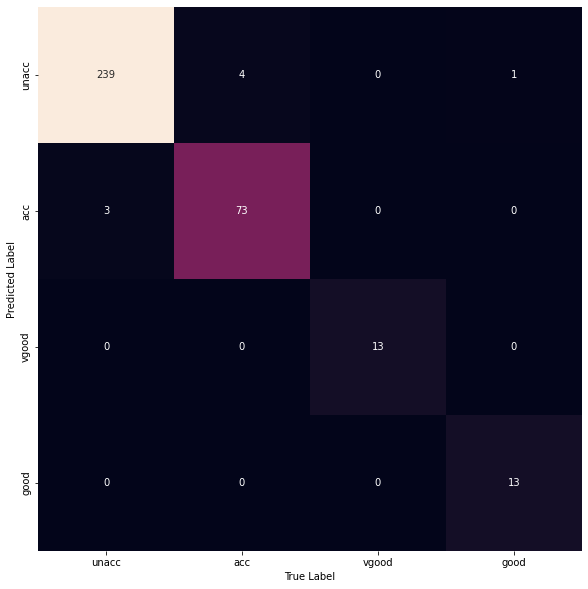

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# construct a confusion matrix which shows the accuracy on each class 
confusion_mat = confusion_matrix(ys_test, ys_test_pred)

# plot the confusion matrix into a heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mat.T, square=True, annot=True, fmt='d',cbar=False,xticklabels=class_dic.values(),yticklabels=class_dic.values())
# set the x and y label of the figure
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()
